In [1]:
### Library functions
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
import random 
from matplotlib import animation
import networkx.algorithms.centrality as nx_centrality
from collections import deque
from matplotlib import animation
import math

/Users/fengboyang/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

## Training dataset

The global parameters of the generate_random_graph function:
1. FAKE_DIFF_ITER: the fake nodes diffusion iteration
2. FAKE_SEED_NUM: the initial fake seed set number
3. NODE_NUM: the graph nodes number
4. EDGE_NUM: the graph edges number 
5. M_INDEX: the generate graph method index

In [2]:
def generate_random_graph(difusion_iteration, method_index,fake_seed_num, num_nodes , num_edges , probability = 0.5,m = 2, radius = None, k_nearest_neighbor = None, degree = None, seed = None):
    random_graph = nx.Graph()
    if method_index == 0:
        random_graph = nx.gnm_random_graph(num_nodes, num_edges)

    elif method_index == 1:
        random_graph = nx.erdos_renyi_graph(num_nodes, probability)

    elif method_index == 2:
         # m means the edges number from the create point to existing point
        random_graph = nx.barabasi_albert_graph(num_nodes, m)

    elif method_index == 3:
        random_graph = nx.watts_strogatz_graph(num_nodes, k_nearest_neighbor, probability)
#     elif method_index == 4:
#         random_graph=nx.gnc_graph(num_nodes)

#     elif method_index == 4:
#         random_graph = nx.random_geometric_graph(num_nodes, radius)   
        
#     elif method_index == 5:
#         random_graph = nx.random_regular_graph(degree, num_nodes)

#     elif method_index == 7:
#         #p1 = nodes in the tree connected,  p2 = nodes in the tree body connected
#         random_graph = nx.random_lobster(num_nodes, probability, probability)

#     elif method_index == 8:
#         p = probability # probability connected with its nearest neighbor
#         q = probability # probability connected with other nodes
#         random_graph = nx.newman_watts_strogatz_graph(num_nodes, p, q)

#     elif method_index == 9:
#         random_graph = nx.create_powerlaw_cluster_graph(num_nodes, k_nearest_neighbor, probability, seed=seed)

#     elif method_index == 10:
#         # A random maximal planar graph is a graph in which every possible edge that can be added without creating a cycle is included, 
#         # resulting in a planar graph with the maximum number of edges. 
#         random_graph = nx.random_maximal_planar_graph(num_nodes)

#     elif method_index == 11:
#         random_graph = nx.random_threshold_graph(num_nodes, probability)

#     elif method_index == 12:
#         random_graph = nx.create_forest_fire_graph(num_nodes, probability, probability, seed=seed)

#     elif method_index == 13:
#         k = k_nearest_neighbor # This k is different with KNN, it generates a scale-free network where new nodes are added with k initial edges
#         random_graph = nx.extended_barabasi_albert_graph(num_nodes, k, probability)


#     elif method_index == 15:
#         # lollipop graph
#         m = num_nodes // 2  # Number of nodes in the complete graph
#         n = num_nodes - m - 1  # Number of nodes in the cycle graph

#         G_complete = nx.complete_graph(m)
#         G_cycle = nx.cycle_graph(n)

#         # Connect the complete graph and cycle graph
#         G_complete.add_edge(m-1, m)
#         random_graph = nx.compose(G_complete, G_cycle)
    
    
    for (u,v) in random_graph.edges:
        if FIXED == True:
            random_graph.edges[u, v]["weight"] = PROBABILITY
        else:
            random_graph.edges[u, v]["weight"] =  random.uniform(0,1)
    for node in random_graph.nodes():
        random_graph.nodes[node]['state'] = 0 # 0初始状态；1:true；2:fake
    node_number = random_graph.number_of_nodes()
    start_node_index = [0] *fake_seed_num
    index_range = range(0,  node_number)
    fake_seed_set = random.sample(index_range, fake_seed_num)
    fake_active_nodes = fake_seed_set.copy()
    fake_nodes_set = fake_seed_set.copy()
    for _ in range(difusion_iteration):
        temp_fake = []
        for v in fake_active_nodes:
            for nbr in random_graph.neighbors(v): 
                if random_graph.nodes[nbr]['state'] == 0 : 
                    edge_data = random_graph.get_edge_data(v, nbr)
                    if random.uniform(0, 1) < edge_data['weight']:
                        fake_nodes_set.append(nbr)
                        temp_fake.append(nbr)
                        random_graph.nodes[nbr]['state'] = 2
        fake_active_nodes = temp_fake.copy()
        temp_fake.clear()    
    for node in fake_nodes_set:
        random_graph.nodes[node]['state'] = 2
        
    return random_graph,fake_active_nodes,fake_seed_set,fake_nodes_set


## Create and normalize test data

In [3]:
# !pip install scanpy

In [4]:
import scanpy as sc 
import scipy as sp
import scipy.sparse  # call as sp.sparse

# filename_ca_HepTh = r"D:\course (Kou Hari)\2023 semaster 1\COMP5703 Capstone\data\ca-HepTh.mtx"
# filename_ca_GrQc = r"D:\course (Kou Hari)\2023 semaster 1\COMP5703 Capstone\data\ca-GrQc.mtx"
# filename_tech_p2p_gnutella = r"D:\course (Kou Hari)\2023 semaster 1\COMP5703 Capstone\data\tech-p2p-gnutella.mtx"
filename_ca_HepTh = 'ca-HepTh.mtx'
filename_ca_GrQc = 'ca-GrQc.mtx'
filename_tech_p2p_gnutella = 'tech-p2p-gnutella.mtx'

In [5]:
def read_graph(filename):
    adata = sc.read(filename)
    G = nx.from_scipy_sparse_array(adata.X, create_using=nx.MultiGraph)
    print("node number:",G.number_of_nodes())
    print("edge number:",G.number_of_edges())
    return G, G.number_of_nodes(), G.number_of_edges()

In [6]:
G_ca_HepTh,N_ca_HepTh,E_ca_HepTh= read_graph(filename_ca_HepTh)

node number: 9877
edge number: 25998


In [7]:
G_ca_GrQc,N_ca_GrQc,E_ca_GrQc = read_graph(filename_ca_GrQc)

node number: 5242
edge number: 14496


In [8]:
G_tech_p2p_gnutella,N_tech_p2p_gnutella,E_tech_p2p_gnutella = read_graph(filename_tech_p2p_gnutella)

node number: 62561
edge number: 147878


In [9]:
def normalization_graph(graph):
    graph_node_number = graph.number_of_nodes()
    graph_edge_number = graph.number_of_edges()
    for node in graph.nodes():
        graph.nodes[node]['state'] = 0
    for (u,v) in graph.edges:
        graph.edges[u,v]['weight'] = random.uniform(0,1)
    return graph,graph_node_number,graph_edge_number

In [10]:
def fake_nodes_diffusion(graph,fake_seed_num,iteration):
    node_number = graph.number_of_nodes()
    start_node_index = [0] *fake_seed_num
    index_range = range(0,  node_number)
    fake_seed_set = random.sample(index_range, fake_seed_num)
    fake_active_nodes = fake_seed_set.copy()
    fake_nodes_set = fake_seed_set.copy()
    for node in fake_seed_set:
        graph.nodes[node]['state'] = 2
    #fake news diffusion
    for _ in range(iteration):
        temp_fake = []
        for v in fake_active_nodes:
            for nbr in graph.neighbors(v): 
                if graph.nodes[nbr]['state'] == 0 : 
                    edge_data = graph.get_edge_data(v, nbr)
                    if random.uniform(0, 1) < edge_data['weight']:
                        fake_nodes_set.append(nbr)
                        temp_fake.append(nbr)
                        graph.nodes[nbr]['state'] = 2
        fake_active_nodes = temp_fake.copy()  
    for node in fake_nodes_set:
        random_graph.nodes[node]['state'] = 2
    return graph,fake_active_nodes

In [11]:
def statistic_draw_graph(Graph,draw = False):
    color_list = []
    fake = 0
    true = 0
    normal = 0
    for node in Graph.nodes():
        if Graph.nodes[node]['state'] == 0:
            normal += 1
            color_list.append('blue')
        elif Graph.nodes[node]['state'] == 1:
            true += 1
            color_list.append('green')
        elif Graph.nodes[node]['state'] == 2:
            fake += 1
            color_list.append('red')
    print("normal nodes number:",normal)
    print("true nodes number:",true)
    print("fake nodes number:",fake)
    print("the edge of graph:",Graph.number_of_edges())
    #nx.draw(Graph, node_color= color_list) 
    if draw:
        nx.draw_circular(Graph, node_color= color_list)
        plt.show()

# Environment Class

The global parameters in the Environment Class:
1. ITERATION: control the diffusion times during the true and fake nodes antagonistic process
2. MAX_STEP: control the max step of this epoch
3. SEED_SIZE: the initial size of the seed set, the initial parameters of Env class.

The input variable of the Env() class:
1. graph: the training graph or testing graph
2. seed_size: SEED_SIZE;the initial size of the seed set
3. fake_set: the initial fake

The functions in the Env class:
1. reset: reset the parameters
2. step: the experiment excuation progress
3. select_initial_seeds: select the initial seed randomly
4. select_initial_seeds_rules: select the intial seed set according to different criterion
5. add_seed: add the seed nodes according to the action number from the agent
6. get_state: get the current state of the graph
7. diffusion_process: the procees of the true and fake nodes antagonistic
8. get_image: draw the image of the graph

In [81]:
class Env():
    def __init__(self, graph,seed_size,fake_set):
        self.graph_initial = graph
        self.seed_size = seed_size
        self.seed_set = []
        self.fake_set = fake_set
        self.state = None
        self.reset()

    def reset(self):
        #select the seed set:
        self.graph = self.graph_initial.copy()
        self.step_count = 0
        self.add_number = 0
        self.seed_set, action = self.select_initial_seeds_rules(self.graph,self.seed_size)
        self.true_active_nodes = self.seed_set.copy()
        self.fake_active_nodes = self.fake_set.copy()
        self.state = self.get_state()
        return self.state, action
    
    def step(self,action):
        count_state0 = 0
        for node in self.graph.nodes():
            if self.graph.nodes[node]['state'] == 0:
                count_state0 += 1
        if action > 0 and (len(self.seed_set) + ADD_SEED_NUMBER <= self.graph.number_of_nodes()) and count_state0 >= ADD_SEED_NUMBER:
            self.add_number += 1
            centrality_methods = ["None", "random", "degree", "closeness", "betweenness", "eigenvector"]
            centrality_method = centrality_methods[action]
            self.seed_set = self.add_seed(self.graph,self.seed_set,action,ADD_SEED_NUMBER)
            if(self.true_active_nodes[-ADD_SEED_NUMBER:]!= self.seed_set[-ADD_SEED_NUMBER:]):
                self.true_active_nodes.extend(self.seed_set[-ADD_SEED_NUMBER:])
        self.graph,self.true_active_nodes,self.fake_active_nodes = self.diffusion_process(self.graph,
                                                                                     self.true_active_nodes,
                                                                               self.fake_active_nodes,ITERATION)
        #print("current image:")
        #self.get_image(self.graph)
        
        # terminal condition                                                                    
        all_true_nodes = []
        all_fake_nodes = []
        normal_nodes= []                                                                             
        for node in self.graph.nodes():
            if self.graph.nodes[node]['state'] == 1:
                all_true_nodes.append(node)
            elif self.graph.nodes[node]['state'] == 2:
                all_fake_nodes.append(node)
            elif self.graph.nodes[node]['state'] == 0:
                normal_nodes.append(node)
        number_nodes = len(self.graph.nodes())
        number_true_nodes = len(all_true_nodes) 
        number_fake_nodes = len(all_fake_nodes)
        # terminal condition: over the MAX_STEP / less 1% nodes are normal nodes
        terminated = bool(self.step_count >= MAX_STEP 
                        or len(normal_nodes)<=0.01 * number_nodes) 
#         penatly = math.pow(1.2,self.add_number)
#         print("penatly:",penatly)
#         print(len(all_true_nodes)  - len(all_fake_nodes))
        penatly = math.pow(1.05,self.add_number)
        if not terminated:
            if len(all_true_nodes)>len(all_fake_nodes):
                reward = (len(all_true_nodes)  - len(all_fake_nodes) - penatly + 5)/(len(all_true_nodes) + len(all_fake_nodes))
                #print(">:",reward)
            else:
                reward = (len(all_true_nodes)  - len(all_fake_nodes) - penatly)/(len(all_true_nodes) + len(all_fake_nodes))
                
                #print("<:",reward)
            done = False
            self.step_count +=1
        else: 
            # when this iteration is end, give a little big reward.
            reward = 30
            done = True
#         if not terminated:
#             if len(all_true_nodes)>len(all_fake_nodes):
#                 reward = (len(all_true_nodes)  - len(all_fake_nodes) - penatly )/(len(all_true_nodes) + len(all_fake_nodes))#+0.7
#                 print(">:",reward)
#             else:
#                 reward = (len(all_true_nodes)  - len(all_fake_nodes))/(len(all_true_nodes) + len(all_fake_nodes)) #-0.5
#                 print("<:",reward)
#             done = False
#             self.step_count +=1
#         else:
#             reward = 10 +  (MAX_STEP - self.step_count) * 0.25
#             done = True
            
#             self.step_count >= MAX_STEP: 
#             # when this iteration is end, give a little big reward.
#             reward = 20
#             done = True
#         elif len(normal_nodes)<=0.01 * number_nodes:
#             reward = 30
#             done = True
        self.state = self.get_state()
        return self.state, reward ,done 
    # select the initial seed set randomly
    def select_initial_seeds(self, graph, seed_number):
        node_number = graph.number_of_nodes()
        start_node_index = [0] *seed_number
        index_range = range(0,  node_number)
        start_node_index = random.sample(index_range, seed_number)
        for node in graph.nodes():
            if node in start_node_index:
                graph.nodes[node]['state'] = 1
        return start_node_index
    # select the initial seed set according to different rules
    def select_initial_seeds_rules(self,graph,seed_number):
        # 1 random 2 "degree",3 "closeness", 4"betweenness", 5"eigenvector"
        action = random.randint(0,5)
        start_node_index = []
        centrality_scores = []
        if action == 0:   
            node_number = graph.number_of_nodes()
            start_node_index = [0] *seed_number
            index_range = range(0,  node_number)
            start_node_index = random.sample(index_range, seed_number)
        else:
            if action == 1:
                centrality_scores  = list(nx_centrality.degree_centrality(self.graph).values())
            elif action == 2:
                centrality_scores  = list(nx_centrality.degree_centrality(self.graph).values())
            elif action == 3:
                centrality_scores = list(nx_centrality.closeness_centrality(self.graph).values())
            elif action == 4:
                centrality_scores = list(nx_centrality.betweenness_centrality(self.graph).values())
            elif action == 5:
                centrality_scores = list(nx_centrality.eigenvector_centrality(self.graph).values())
            for _ in range(seed_number):
                max_number = max(centrality_scores)
                index = centrality_scores.index(max_number)
                while(graph.nodes[index]['state'] != 0):
                    centrality_scores[index] = -1
                    max_number = max(centrality_scores)
                    index = centrality_scores.index(max_number)  
                start_node_index.append(index)
                centrality_scores[index] = -1
        for node in graph.nodes():
            if node in start_node_index:
                graph.nodes[node]['state'] = 1
        return start_node_index,action
        
    def add_seed(self,graph,seed_set,action,add_number):
        # 1 random 2 "degree",3 "closeness", 4"betweenness", 5"eigenvector"
        new_seed_set = []
        new_seed_set = seed_set.copy()
        centrality_scores = []
        state0 = 0
        for node in graph.nodes():
            if graph.nodes[node]['state'] == 0:
                state0 += 1
        if state0 >= ADD_SEED_NUMBER:
            if action == 1:
                node_number = graph.number_of_nodes()
                for _ in range(ADD_SEED_NUMBER):
                    index = random.randint(0,node_number-1)
                    while (index in seed_set) or (graph.nodes[index]['state'] in [1,2])  :
                        index = random.randint(0,node_number-1)
                    new_seed_set.append(index)
                    graph.nodes[index]['state']  = 1

            else: 
                if action == 2:
                    centrality_scores  = list(nx_centrality.degree_centrality(self.graph).values())
                elif action == 3:
                    centrality_scores = list(nx_centrality.closeness_centrality(self.graph).values())
                elif action == 4:
                    centrality_scores = list(nx_centrality.betweenness_centrality(self.graph).values())
                elif action == 5:
                    centrality_scores = list(nx_centrality.eigenvector_centrality(self.graph).values())
                for node in seed_set:
                    centrality_scores[node] = -1
                for _ in range(ADD_SEED_NUMBER):
                    index = centrality_scores.index(max(centrality_scores))
                    while(graph.nodes[index]['state'] != 0):
                        index = centrality_scores.index(max(centrality_scores))
                        # print(index)
                        centrality_scores[index] = -1
                    # print("add_seed, index:",index)
                    new_seed_set.append(index)
                    graph.nodes[index]['state'] = 1
                    centrality_scores[index] = -1
        return new_seed_set
    def get_state(self):
        node_state = []
        for node in self.graph.nodes():
            node_state.append(self.graph.nodes[node]['state'])
        return nx.to_numpy_array(self.graph), len(self.seed_set), node_state
    
    def diffusion_process(self, G ,true_active_set,fake_active_set,itertaion):
        G = self.graph.copy()
        true_active_nodes = true_active_set.copy()
        fake_active_nodes = fake_active_set.copy()
        # print("true_active_nodes begin:",true_active_nodes)
        # print("fake_active_nodes begin:",fake_active_nodes)
        for _ in range(itertaion):
            tmp_true_nodes ={}
            for v in true_active_nodes: 
                for nbr in G.neighbors(v):
                    if G.nodes[nbr]['state'] in [0]:
                        edge_data = G.get_edge_data(v, nbr)
                        random_possibility = random.uniform(0, 1)
                        if random_possibility < edge_data['weight']:
                            G.nodes[nbr]['state'] == 3
                            tmp_true_nodes.update({nbr:random_possibility})
                            true_active_set.append(nbr)
                    else:
                        continue
            tmp_fake_nodes ={}
            for v in fake_active_nodes:
                for nbr in G.neighbors(v):
                    if G.nodes[nbr]['state'] in [0,3]:
                        edge_data = G.get_edge_data(v, nbr)
                        random_possibility = random.uniform(0, 1)
                        if random_possibility < edge_data['weight']:
                            tmp_fake_nodes.update({nbr:random_possibility})
                            fake_active_set.append(nbr)
                            G.nodes[nbr]['state'] == 4
            true_active_nodes = list(tmp_true_nodes.keys())
            fake_active_nodes = list(tmp_fake_nodes.keys())
            for node in tmp_true_nodes.keys():
                if node in tmp_fake_nodes.keys() :
                    if tmp_true_nodes.get(node) >= tmp_fake_nodes.get(node):
                        fake_active_set.remove(node)
                        fake_active_nodes.remove(node)
                    elif tmp_true_nodes.get(node) < tmp_fake_nodes.get(node):
                        true_active_set.remove(node)
                        true_active_nodes.remove(node)
                else:
                    continue
            for node in true_active_set:
                G.nodes[node]['state'] = 1
            for node in fake_active_set:
                G.nodes[node]['state'] = 2
            # print("true_active_nodes",true_active_set)
            # print("fake_active_nodes",fake_active_set)
        return G,true_active_nodes,fake_active_nodes

        
    def get_image(self,Graph):
        color_list = []
        for node in Graph.nodes():
            if Graph.nodes[node]['state'] == 0:
                color_list.append('blue')
            elif Graph.nodes[node]['state'] == 1:
                color_list.append('green')
            elif Graph.nodes[node]['state'] == 2:
                color_list.append('red')
        #nx.draw(Graph, node_color= color_list) 
        nx.draw_circular(Graph, node_color= color_list)
        plt.show()

# Agent

##  Device: GPU/CPU
Note:

if you use Macbook with Apple M1/M2 core, please run the code in the Mac Device;

if you use Windows with CUDA core, please run the code in the Windows Device;

### Mac Device

In [13]:
# # if use MAC(Apple M1/M2) please run the follow codes
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


### Windows Device

In [15]:
import torch
print("CUDA Available:", torch.cuda.is_available())

CUDA Available: False


In [16]:
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name()
    print("GPU Device Name:", device_name)

In [17]:
if torch.backends.cudnn.is_available():
    print("cuDNN Available")

In [18]:
# if use CUDA please run the follow codes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## DQN Agent

The input variable of the DQNAgent() class link to the global parameters:
1. state_dim: STATE_DIM; Dimension of state
2. action_dim: ACT_DIM; Dimension of action space 
3. learning_rate: LR;
4. gamma: GAMMA
5. epsilon: EPSILON
6. epsilon_decay: EPSILON_DECAY

In [14]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate, gamma, epsilon, epsilon_decay):
        self.q_network = QNetwork(state_dim, action_dim).to(device)
        self.target_network = QNetwork(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.memory = deque(maxlen=10000)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, action_dim)
        else:
            state = torch.tensor(state, dtype=torch.float32).to(device)
            q_values = self.q_network(state)
#           q_values = self.q_network(torch.tensor(state, dtype=torch.float32))
            return torch.argmax(q_values.cpu()).item()

    def remember(self, state, action, reward, next_state, done):
        #state = torch.tensor(state).float().unsqueeze(0)  # ensure state is a tensor
        self.memory.append((state, action, reward, next_state, done))

    def train(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)

        for state, action, reward, next_state, done in minibatch:
            #print("next_state:", next_state)
            #state = torch.tensor(state, dtype=torch.float32).to(device)
            state_tensor = state_to_tensor(state).to(device)
            #print(state_tensor.shape)
            #print(self.q_network(state_tensor).shape)
            action_index = torch.tensor(action, dtype=torch.long)
            target = self.q_network(state_tensor)[0, action_index]
            #target = self.q_network(state_tensor)[action]
            if done:
                target_value = reward
            else:
                next_state_tensor = state_to_tensor(next_state).to(device)
                #next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
                next_q_values = self.target_network(next_state_tensor).detach()
                target_value = reward + self.gamma * torch.max(next_q_values).item()

            #loss = self.loss_fn(target, torch.tensor(float(target_value)))
            loss = self.loss_fn(target, torch.tensor(float(target_value)).to(device))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        self.epsilon *= self.epsilon_decay

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def save(self, path):
        torch.save(self.q_network.state_dict(), path)

    def load(self, path):
        self.q_network.load_state_dict(torch.load(path))
        self.target_network.load_state_dict(self.q_network.state_dict())

### Transform array state to tensor state

In [15]:
def state_to_tensor(state):
    graph, num_seed_nodes, node_state = state
    
    graph_tensor = torch.tensor(graph, dtype=torch.float32).view(-1).unsqueeze(0)
    num_seed_nodes_tensor = torch.tensor([num_seed_nodes], dtype=torch.float32).unsqueeze(0)
    node_state_tensor = torch.tensor(node_state, dtype=torch.float32).unsqueeze(0)
    
#     state_tensor = torch.cat((graph_tensor, num_seed_nodes_tensor, node_state_tensor), dim=1)
    state_tensor = torch.cat((num_seed_nodes_tensor, node_state_tensor), dim=1)
    
    return state_tensor

## Neural Network

In [16]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)# (2500 + 50 + 2) (10000 + 100 + 2)
        
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training Function
The input valiable of train_dqn function:

1. agent: the initialized Agent class
2. env: the initialized Env class
3. batch_size: BATCH_SIZE
4. update_target_every: UPDATE;How many iterations to update the network
5. dqn_agent_name: the name of DQN agent, the file extension is '.pth'
6. brenchmark_action: Start benchmark comparison and specifying an action(1-5)
7. Demo: Whether state should be displayed or saved each time

In [17]:
def train_dqn(agent, env, episodes, batch_size, update_target_every,dqn_agent_name  = None,brenchmark_action = None,Demo = False):
    state_history= []
    rewards_list = []
    for episode in range(episodes):
        state,init_action = env.reset()
        if brenchmark_action is not None:
            init_action = brenchmark_action
        #print(state)
#         state = torch.tensor(state).float().unsqueeze(0)  # ensure state is a tensor
        total_reward = 0
        done = False

        while not done:
            state_tensor = state_to_tensor(state)
            #print(state_tensor)
            if brenchmark_action is not None:
                action = brenchmark_action
            else:
                action = agent.get_action(state_tensor)
            next_state, reward, done = env.step(action)
            #print(next_state)
            agent.remember(state, action, reward, next_state, done)
            agent.train(batch_size)
            total_reward += reward
            state = next_state
            if Demo:
                state_history.append(state)  # Add current state to state_history
        if not Demo:
            state_history.append(state)
        rewards_list.append(total_reward)
        if episode % update_target_every == 0:
            agent.update_target_network()

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")
    if dqn_agent_name is not None:
        torch.save(agent, dqn_agent_name)
    return state_history, rewards_list

# Testing Function

In [188]:
def test_dqn(model, agent, env, episodes):
    rewards_list = []

    for episode in range(episodes):
        state,init_action = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_tensor = state_to_tensor(state)
            action = agent.get_action(state_tensor)
            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state
            
        rewards_list.append(total_reward)

        print(f"Test Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")
        
    return rewards_list

# Display functions

## Display the training or testing process

In [19]:
import matplotlib.pyplot as plt
from matplotlib import animation

In [20]:
def state2graph(state):
    graph = nx.from_numpy_array(state[0])
    #print(graph.nodes())
    for node in graph.nodes():
        graph.nodes[node]['state'] = state[2][node]
    return graph

In [21]:
def create_color_list(graph):
    color_list = []
    #create color list
    #print(graph)
    for node in graph.nodes():
        if graph.nodes[node]['state'] == 0:
            color_list.append('blue')
        elif graph.nodes[node]['state'] == 1:
            color_list.append('green')
        elif graph.nodes[node]['state'] == 2:
            color_list.append('red')
    return color_list

In [144]:
def define_pos(state):
    graph = nx.from_numpy_array(state[0])
    #position = spring_layout(graph)
    position = nx.circular_layout(graph)   
    return position

In [184]:
def display(state):
    plt.figure(figsize=(10,10))
    fig, ax = plt.subplots()
    graph = state2graph(state[0])
    pos = define_pos(state[0])
    color_list = create_color_list(graph)
    plt.title("Episodes: 0")
    nx.draw(graph, pos, node_color= color_list)
    color_meanings = {'red': 'Fake', 'blue': 'Normal', 'green': 'True'}
    
    def animate(frame):
        ax.clear()
        #print("frame,",frame)
        #print(state[frame])
        graph = state2graph(state[frame])
        color_list = create_color_list(graph)
        nx.draw(graph, pos, node_color= color_list)
        unique_colors = list(set(color_list))
#         print(unique_colors)
#         for color in unique_colors:
#             print(color)
#             print(color_meanings[color])
        legend_labels = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=color_meanings[color]) for color in unique_colors]
        legend = ax.legend(handles=legend_labels)
        return legend
    anim = animation.FuncAnimation(fig, animate, frames=len(state), interval=200)
    anim.save('train.gif', writer='Pillow')
    #anim.save("train.mkv",writer='ffmpeg')
    
    plt.show()

## Show the change of reward

In [24]:
def reward_image(rewards_list):
    x = range(1,ALL_EPISODES+1)
    print(x)
    plt.plot(x,rewards_list,'s-')
    plt.xlabel("Iteration")
    plt.ylabel("Total reward")
    plt.show()

# Global parameters

In [30]:
# the Global parameter of generate_random_graph
FAKE_DIFF_ITER = 0 # the fake nodes diffusion iteration
FAKE_SEED_NUM = 3 # the initial fake seed set number
NODE_NUM = 100 # the intial graph nodes number
EDGE_NUM = 200 # the intial graph edges number
M_INDEX = 0 # the generate graph method index

# the Global parameter of Env class
ITERATION = 1 #control the diffusion times during the true and fake nodes antagonistic process
MAX_STEP = 40 # control the max step of this epoch
SEED_SIZE = 10 # the initial size of the seed set, the initial parameters of Env class.
ADD_SEED_NUMBER = 1 # the number of nodes that are added to seed set

# the Global parameter of Agentclass
state_dim = NODE_NUM + 1 #state_dim: Dimension of state
action_dim = 6 #action_dim:  Dimension of action space
LR = 0.001#learning_rate: 
GAMMA = 0.99 # gamma:
EPSILON = 1.0# epsilon: 
EPSILON_DECAY = 0.995 # epsilon_decay: 
# the Global parameter of train and test function
batch_size = 128 #batch_size: 
UPDATE = 10 #update_target_every: 
ALL_EPISODES = 200 # total number of iteration times

FIXED = False

# Turn parameters

## Test different reward

In [31]:
# please change the part in the Env class

In [32]:
# test different reward:
#reward 1:
#     penatly = math.pow(1.1,self.add_number)
#     #print("penatly:",penatly)
#     if not terminated:
#         if len(all_true_nodes)>len(all_fake_nodes):
#             reward = (len(all_true_nodes)  - len(all_fake_nodes) - penatly + 5)/(len(all_true_nodes) + len(all_fake_nodes))
#         else:
#             reward = (len(all_true_nodes)  - len(all_fake_nodes) - penatly)/(len(all_true_nodes) + len(all_fake_nodes))
#         done = False
#         self.step_count +=1
#     else: 
#         # when this iteration is end, give a little big reward.
#         reward = 30
#         done = True

In [33]:
intial_train_graph_reward1,active_fake_set_reward1,intial_fake_set_reward1,all_fake_nodes_reward1 = generate_random_graph(FAKE_DIFF_ITER,M_INDEX,FAKE_SEED_NUM,NODE_NUM, EDGE_NUM )
SEED_SIZE = len(active_fake_set_reward1)
print("SEED_SIZE",SEED_SIZE)
env_reward1 = Env(intial_train_graph_reward1, SEED_SIZE, active_fake_set_reward1)
agent_reward1 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)
state_history_reward1, rewards_list_reward1 = train_dqn(agent_reward1, env_reward1, ALL_EPISODES, batch_size ,UPDATE,Demo= False)

SEED_SIZE 3
Episode 1/200, Total Reward: 42.56554634338571
Episode 2/200, Total Reward: 40.394545825640506
Episode 3/200, Total Reward: 36.39312531303678
Episode 4/200, Total Reward: 42.60822107811981
Episode 5/200, Total Reward: 49.81247390497213


/var/folders/qd/bz9f8bp52sv9260n6zps4vbr0000gn/T/ipykernel_1187/545150970.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Episode 6/200, Total Reward: 42.25154611263352
Episode 7/200, Total Reward: 42.77283456791893
Episode 8/200, Total Reward: 41.863069350932264
Episode 9/200, Total Reward: 42.32250721345501
Episode 10/200, Total Reward: 44.74636122830057
Episode 11/200, Total Reward: 45.08216953925851
Episode 12/200, Total Reward: 42.42483974333985
Episode 13/200, Total Reward: 40.21270435779029
Episode 14/200, Total Reward: 41.263187912277424
Episode 15/200, Total Reward: 45.8796353479936
Episode 16/200, Total Reward: 36.71898146453619
Episode 17/200, Total Reward: 41.24629268403083
Episode 18/200, Total Reward: 40.76439195481053
Episode 19/200, Total Reward: 44.90682158833184
Episode 20/200, Total Reward: 35.4154161406408
Episode 21/200, Total Reward: 36.588615847961094
Episode 22/200, Total Reward: 36.77242562542348
Episode 23/200, Total Reward: 39.7021113707463
Episode 24/200, Total Reward: 43.55138127493784
Episode 25/200, Total Reward: 41.778621331215014
Episode 26/200, Total Reward: 40.6796178100

Episode 175/200, Total Reward: 50.2812150710051
Episode 176/200, Total Reward: 52.054898829165396
Episode 177/200, Total Reward: 50.82176269609464
Episode 178/200, Total Reward: 54.8657981710734
Episode 179/200, Total Reward: 48.79597422606996
Episode 180/200, Total Reward: 55.01315021425933
Episode 181/200, Total Reward: 50.50327129794263
Episode 182/200, Total Reward: 47.30725956514803
Episode 183/200, Total Reward: 56.0100375116764
Episode 184/200, Total Reward: 52.19253492833135
Episode 185/200, Total Reward: 46.309311670034376
Episode 186/200, Total Reward: 49.41269944236481
Episode 187/200, Total Reward: 49.93553013482468
Episode 188/200, Total Reward: 49.228018389494196
Episode 189/200, Total Reward: 48.5817019068967
Episode 190/200, Total Reward: 58.872014744465815
Episode 191/200, Total Reward: 55.76164541723
Episode 192/200, Total Reward: 58.85112829453547
Episode 193/200, Total Reward: 37.741315412515874
Episode 194/200, Total Reward: 49.93569816398838
Episode 195/200, Total

In [35]:
#     penatly = math.pow(1.05,self.add_number)
#     if not terminated:
#         if len(all_true_nodes)>len(all_fake_nodes):
#             reward = (len(all_true_nodes)  - len(all_fake_nodes) - penatly + 5)/(len(all_true_nodes) + len(all_fake_nodes))
#             #print(">:",reward)
#         else:
#             reward = (len(all_true_nodes)  - len(all_fake_nodes) - penatly)/(len(all_true_nodes) + len(all_fake_nodes))

#             #print("<:",reward)
#         done = False
#         self.step_count +=1
#     else: 
#         # when this iteration is end, give a little big reward.
#         reward = 30
#         done = True

In [36]:
intial_train_graph_reward2,active_fake_set_reward2,intial_fake_set_reward2,all_fake_nodes_reward2 = generate_random_graph(FAKE_DIFF_ITER,M_INDEX,FAKE_SEED_NUM,NODE_NUM, EDGE_NUM )
SEED_SIZE = len(active_fake_set_reward2)
print("SEED_SIZE",SEED_SIZE)
env_reward2 = Env(intial_train_graph_reward2, SEED_SIZE, active_fake_set_reward2)
agent_reward2 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)
state_history_reward2, rewards_list_reward2 = train_dqn(agent_reward2, env_reward2, ALL_EPISODES, batch_size ,UPDATE,Demo= False)

SEED_SIZE 3
Episode 1/200, Total Reward: 36.84650931947895
Episode 2/200, Total Reward: 46.7845702640836
Episode 3/200, Total Reward: 45.192144726585276
Episode 4/200, Total Reward: 43.870258573739946
Episode 5/200, Total Reward: 42.12700117212491
Episode 6/200, Total Reward: 40.60981331362566


/var/folders/qd/bz9f8bp52sv9260n6zps4vbr0000gn/T/ipykernel_1187/545150970.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Episode 7/200, Total Reward: 36.000218328612895
Episode 8/200, Total Reward: 40.94048723107713
Episode 9/200, Total Reward: 40.85548861742371
Episode 10/200, Total Reward: 44.92523594430541
Episode 11/200, Total Reward: 43.24410437540305
Episode 12/200, Total Reward: 41.43245174609647
Episode 13/200, Total Reward: 44.45692131306363
Episode 14/200, Total Reward: 33.94264079273748
Episode 15/200, Total Reward: 38.356826594023765
Episode 16/200, Total Reward: 38.89700180482096
Episode 17/200, Total Reward: 50.339388305831605
Episode 18/200, Total Reward: 46.08396749972593
Episode 19/200, Total Reward: 47.4591620358828
Episode 20/200, Total Reward: 44.06990849310463
Episode 21/200, Total Reward: 36.85021665528197
Episode 22/200, Total Reward: 60.72168622911428
Episode 23/200, Total Reward: 62.03647744861012
Episode 24/200, Total Reward: 42.40979655203407
Episode 25/200, Total Reward: 38.830491192738364
Episode 26/200, Total Reward: 62.90521792876517
Episode 27/200, Total Reward: 39.9343201

Episode 176/200, Total Reward: 53.28372689732936
Episode 177/200, Total Reward: 57.07671536149479
Episode 178/200, Total Reward: 55.98505740479311
Episode 179/200, Total Reward: 62.85775181242465
Episode 180/200, Total Reward: 48.856239159519674
Episode 181/200, Total Reward: 54.617562522494495
Episode 182/200, Total Reward: 47.67751874339902
Episode 183/200, Total Reward: 48.31827997596005
Episode 184/200, Total Reward: 47.79221063859627
Episode 185/200, Total Reward: 62.3396858352653
Episode 186/200, Total Reward: 65.63878957883527
Episode 187/200, Total Reward: 61.91457571493629
Episode 188/200, Total Reward: 58.752573458900656
Episode 189/200, Total Reward: 50.34852030116538
Episode 190/200, Total Reward: 53.88331432843935
Episode 191/200, Total Reward: 56.54555402393652
Episode 192/200, Total Reward: 48.1335593342396
Episode 193/200, Total Reward: 47.87136648035282
Episode 194/200, Total Reward: 57.10343451349421
Episode 195/200, Total Reward: 56.29490561485244
Episode 196/200, To

In [38]:
#     penatly = math.pow(1.2,self.add_number)
#     if not terminated:
#         if len(all_true_nodes)>len(all_fake_nodes):
#             reward = (len(all_true_nodes)  - len(all_fake_nodes) - penatly + 5)/(len(all_true_nodes) + len(all_fake_nodes))
#             #print(">:",reward)
#         else:
#             reward = (len(all_true_nodes)  - len(all_fake_nodes) - penatly)/(len(all_true_nodes) + len(all_fake_nodes))

#             #print("<:",reward)
#         done = False
#         self.step_count +=1
#     else: 
#         # when this iteration is end, give a little big reward.
#         reward = 30
#         done = True

In [39]:
intial_train_graph_reward3,active_fake_set_reward3,intial_fake_set_reward3,all_fake_nodes_reward3 = generate_random_graph(FAKE_DIFF_ITER,M_INDEX,FAKE_SEED_NUM,NODE_NUM, EDGE_NUM )
SEED_SIZE = len(active_fake_set_reward3)
print("SEED_SIZE",SEED_SIZE)
env_reward3 = Env(intial_train_graph_reward3, SEED_SIZE, active_fake_set_reward3)
agent_reward3 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)
state_history_reward3, rewards_list_reward3 = train_dqn(agent_reward3, env_reward3, ALL_EPISODES, batch_size ,UPDATE,Demo= False)

SEED_SIZE 3
Episode 1/200, Total Reward: 28.60705072691781
Episode 2/200, Total Reward: 31.888555424736776
Episode 3/200, Total Reward: 39.78310435839741
Episode 4/200, Total Reward: 36.913741730547784
Episode 5/200, Total Reward: 40.97520131661331


/var/folders/qd/bz9f8bp52sv9260n6zps4vbr0000gn/T/ipykernel_1187/545150970.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Episode 6/200, Total Reward: 33.743048176221734
Episode 7/200, Total Reward: 38.91798706719864
Episode 8/200, Total Reward: 29.202007176137318
Episode 9/200, Total Reward: 37.464406055843305
Episode 10/200, Total Reward: 26.820410202925224
Episode 11/200, Total Reward: 26.41417137732396
Episode 12/200, Total Reward: 32.85505091214437
Episode 13/200, Total Reward: 44.26547404466794
Episode 14/200, Total Reward: 39.74710642958503
Episode 15/200, Total Reward: 42.76596233477584
Episode 16/200, Total Reward: 24.014291547257194
Episode 17/200, Total Reward: 38.52988310091595
Episode 18/200, Total Reward: 41.11769108920101
Episode 19/200, Total Reward: 45.681441332802805
Episode 20/200, Total Reward: 20.198595604016013
Episode 21/200, Total Reward: 34.36908523007472
Episode 22/200, Total Reward: 37.00146939842349
Episode 23/200, Total Reward: 29.698667886014526
Episode 24/200, Total Reward: 34.82441264642961
Episode 25/200, Total Reward: 35.07666570144094
Episode 26/200, Total Reward: 30.448

Episode 174/200, Total Reward: 45.34146480889153
Episode 175/200, Total Reward: 30.72393550445176
Episode 176/200, Total Reward: 30.20800193843226
Episode 177/200, Total Reward: 31.00025325154864
Episode 178/200, Total Reward: 37.447895527825494
Episode 179/200, Total Reward: 33.37288388017858
Episode 180/200, Total Reward: 44.03533533496761
Episode 181/200, Total Reward: 47.27332663192553
Episode 182/200, Total Reward: 51.50274840948495
Episode 183/200, Total Reward: 32.436794601174014
Episode 184/200, Total Reward: 46.50048108240538
Episode 185/200, Total Reward: 31.78635764646869
Episode 186/200, Total Reward: 37.16234367933803
Episode 187/200, Total Reward: 48.49773957563143
Episode 188/200, Total Reward: 44.45622552745446
Episode 189/200, Total Reward: 27.4007247757315
Episode 190/200, Total Reward: 39.56871427346336
Episode 191/200, Total Reward: 39.23009236451575
Episode 192/200, Total Reward: 54.616366640490625
Episode 193/200, Total Reward: 37.37372787592843
Episode 194/200, T

range(1, 201)


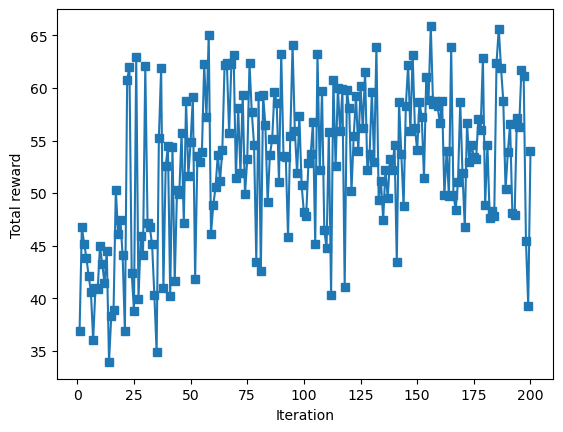

In [41]:
reward_image(rewards_list_reward2)

In [ ]:
#style =bmh,ggplot,dark_background,fivethirtyeight,grayscale。

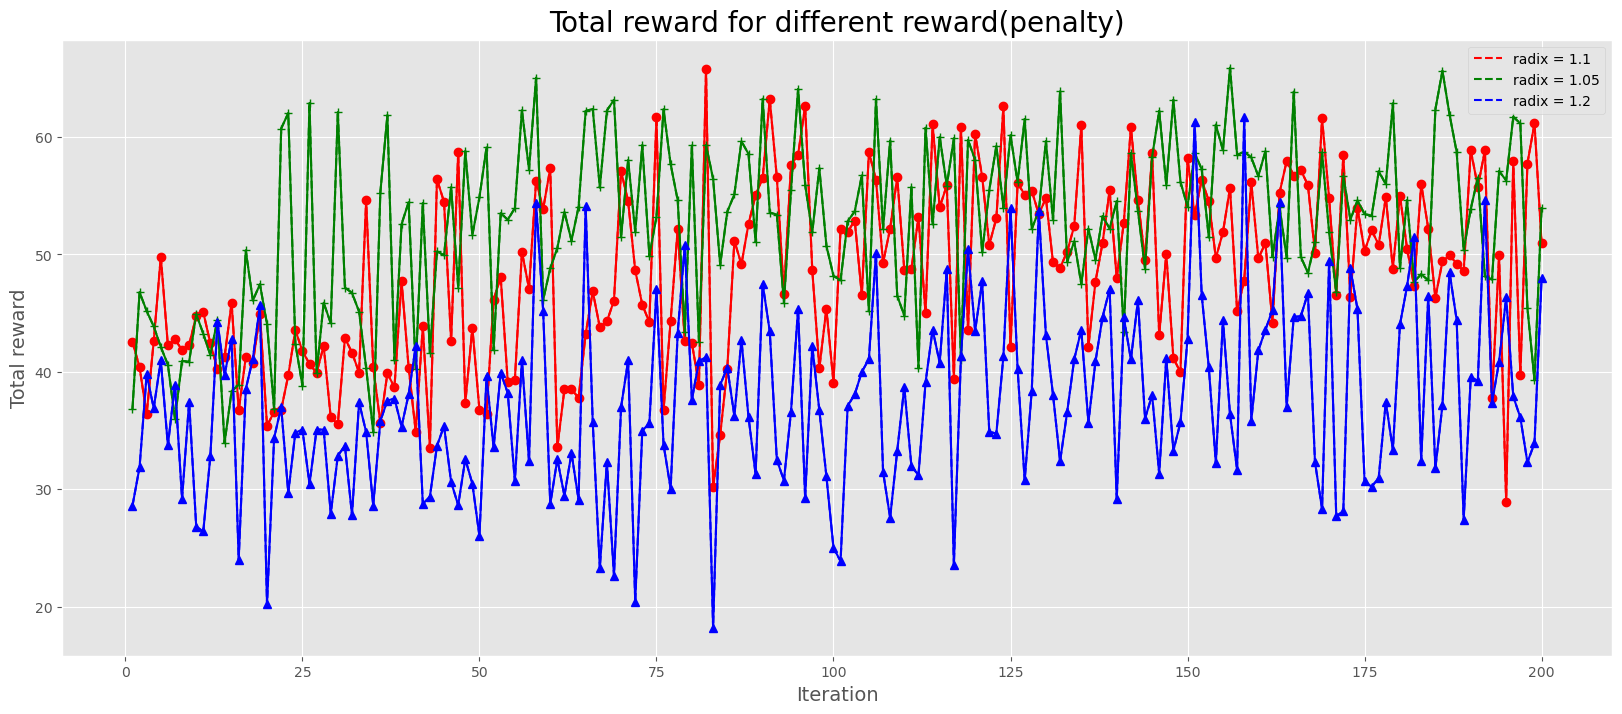

In [61]:
plt.figure(figsize=(20,8))
x = range(1,ALL_EPISODES+1)
plt.style.use('ggplot')
l1=plt.plot(x,rewards_list_reward1,'r--',label='radix = 1.1')
l2=plt.plot(x,rewards_list_reward2,'g--',label='radix = 1.05')
l3=plt.plot(x,rewards_list_reward3,'b--',label='radix = 1.2')
plt.plot(x,rewards_list_reward1,'ro-',x,rewards_list_reward2,'g+-',x,rewards_list_reward3,'b^-')
plt.xlabel("Iteration", size = 14)
plt.ylabel("Total reward",size =14)
plt.title("Total reward for different reward(penalty)",size =20)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


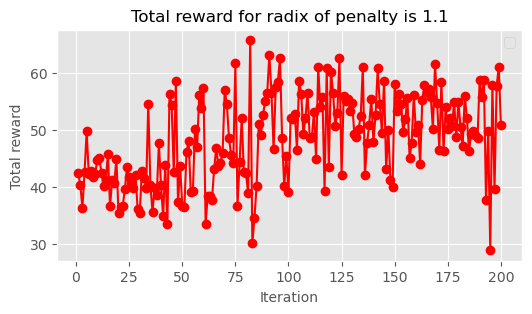

In [71]:
plt.figure(figsize=(6,3))
x = range(1,ALL_EPISODES+1)
plt.style.use('ggplot')
#plt.plot(x,rewards_list_reward1,'r--',label='radix = 1.1')
# l2=plt.plot(x,rewards_list_reward2,'g--',label='radix = 1.05')
# l3=plt.plot(x,rewards_list_reward3,'b--',label='radix = 1.2')
plt.plot(x,rewards_list_reward1,'ro-')
plt.xlabel("Iteration",size = 10)
plt.ylabel("Total reward",size = 10)
plt.title("Total reward for radix of penalty is 1.1",size =12)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


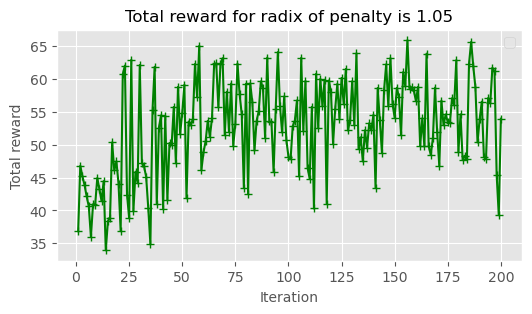

In [82]:
plt.figure(figsize=(6,3))
x = range(1,ALL_EPISODES+1)
plt.style.use('ggplot')
plt.plot(x,rewards_list_reward2,'g+-')
plt.xlabel("Iteration",size = 10)
plt.ylabel("Total reward",size = 10)
plt.title("Total reward for radix of penalty is 1.05",size =12)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


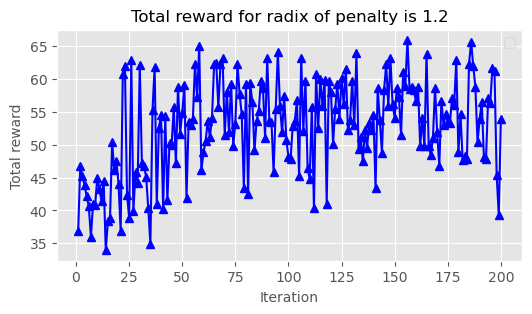

In [83]:
plt.figure(figsize=(6,3))
x = range(1,ALL_EPISODES+1)
plt.style.use('ggplot')
plt.plot(x,rewards_list_reward2,'b^-')
plt.xlabel("Iteration",size = 10)
plt.ylabel("Total reward",size = 10)
plt.title("Total reward for radix of penalty is 1.2",size =12)
plt.legend()
plt.show()

## Test different size of seed set and produce the display Demo
Determine the size of the initial set of true nodes as the number of currently fake active nodes

And build the demo for display

In [84]:
# the Global parameter of generate_random_graph
DEMO_FAKE_DIFF_ITER = 1 # the fake nodes diffusion iteration
DEMO_FAKE_SEED_NUM = 3 # the initial fake seed set number
DEMO_NODE_NUM = 100 # the intial graph nodes number
DEMO_EDGE_NUM = 240 # the intial graph edges number
DEMO_M_INDEX = 0 # the generate graph method index

# the Global parameter of Env class
ITERATION = 1 #control the diffusion times during the true and fake nodes antagonistic process
MAX_STEP = 40 # control the max step of this epoch
DEMO_SEED_SIZE = 5 # the initial size of the seed set, the initial parameters of Env class.
ADD_SEED_NUMBER = 1 # the number of nodes that are added to seed set

# the Global parameter of Agentclass
state_dim = DEMO_NODE_NUM + 1 #state_dim: Dimension of state
action_dim = 6 #action_dim:  Dimension of action space
LR = 0.001#learning_rate: 
GAMMA = 0.99 # gamma:
EPSILON = 1.0# epsilon: 
EPSILON_DECAY = 0.995 # epsilon_decay: 
# the Global parameter of train and test function
batch_size = 128 #batch_size: 
UPDATE = 10 #update_target_every: 
ALL_EPISODES = 200 # total number of iteration times


In [85]:
Demo_intial_train_graph,Demo_active_fake_set,Demo_intial_fake_set,Demo_all_fake_nodes = generate_random_graph(DEMO_FAKE_DIFF_ITER,DEMO_M_INDEX,DEMO_FAKE_SEED_NUM,DEMO_NODE_NUM, DEMO_EDGE_NUM )

The initial fake seed size is  3
The number of fake nodes diffusion iteration is  0
normal nodes number: 97
true nodes number: 0
fake nodes number: 3
the edge of graph: 240


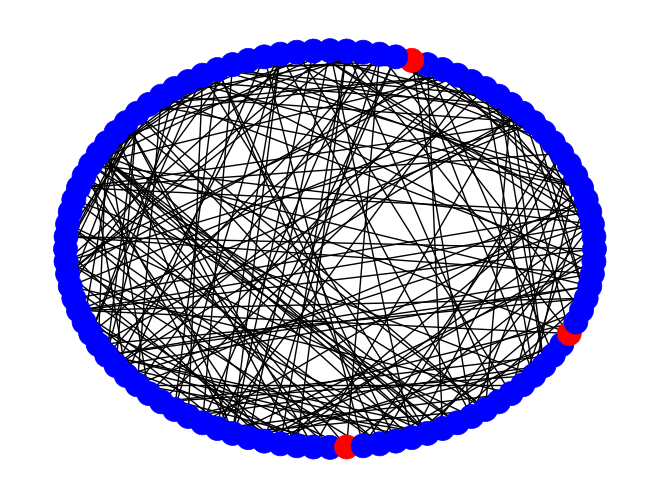

The number of fake nodes diffusion iteration is  1
normal nodes number: 91
true nodes number: 0
fake nodes number: 9
the edge of graph: 240


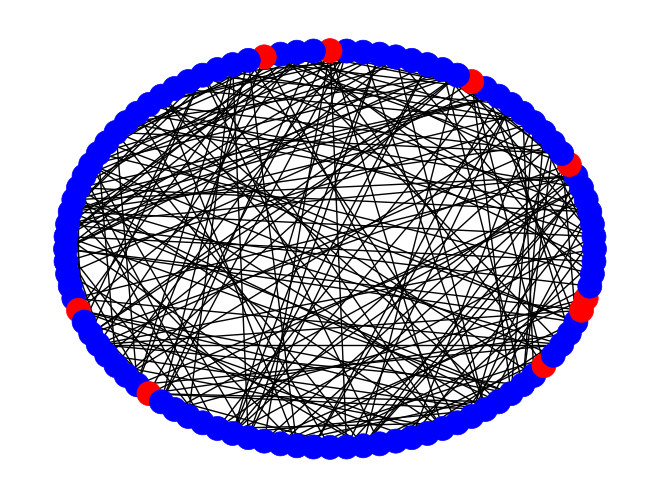

The number of fake nodes diffusion iteration is  2
normal nodes number: 87
true nodes number: 0
fake nodes number: 13
the edge of graph: 240


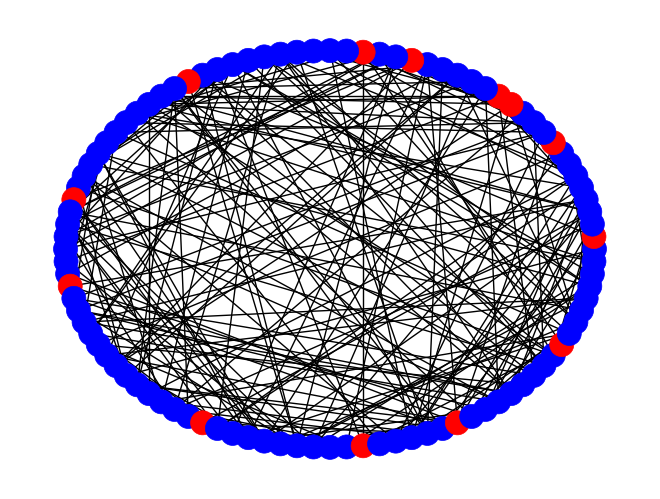

The number of fake nodes diffusion iteration is  3
normal nodes number: 48
true nodes number: 0
fake nodes number: 52
the edge of graph: 240


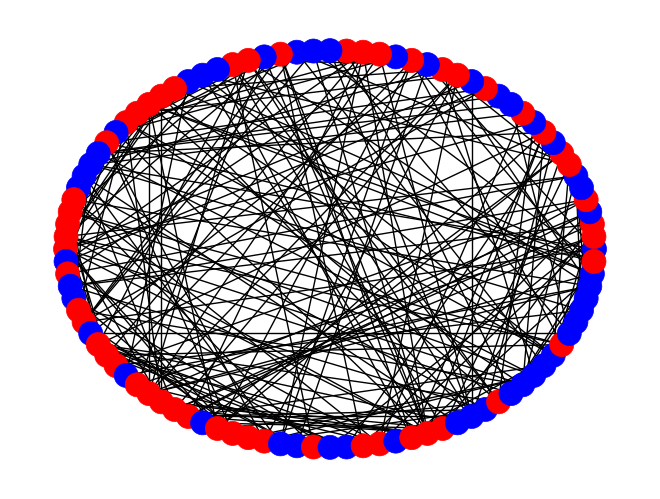

In [86]:
print("The initial fake seed size is ",DEMO_FAKE_SEED_NUM)
i = 0
while i <= 3 : 
    print("The number of fake nodes diffusion iteration is ",i)
    Demo_intial_train_graph,Demo_active_fake_set,Demo_intial_fake_set,Demo_all_fake_nodes = generate_random_graph(i,DEMO_M_INDEX,DEMO_FAKE_SEED_NUM,DEMO_NODE_NUM, DEMO_EDGE_NUM )
    statistic_draw_graph(Demo_intial_train_graph, draw = True)
    i +=1

##  Use the DEMO_FAKE_DIFF_ITER = 0,1,2 

### DEMO_FAKE_DIFF_ITER = 0

In [92]:
DEMO_FAKE_DIFF_ITER = 0
Demo_intial_train_graph0,Demo_active_fake_set0,Demo_intial_fake_set0,Demo_all_fake_nodes0 = generate_random_graph(DEMO_FAKE_DIFF_ITER,DEMO_M_INDEX,DEMO_FAKE_SEED_NUM,DEMO_NODE_NUM, DEMO_EDGE_NUM )
DEMO_SEED_SIZE = len(Demo_intial_fake_set0)
print(DEMO_SEED_SIZE)

3


In [93]:
Demo_env0 = Env(Demo_intial_train_graph0, DEMO_SEED_SIZE, Demo_active_fake_set0)

In [94]:
Demo_agent0 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)

In [95]:
state_history0, rewards_list0 = train_dqn(Demo_agent0, Demo_env0, ALL_EPISODES, batch_size ,UPDATE, dqn_agent_name ="Demo0.pth",Demo= True)

Episode 1/200, Total Reward: 37.30532265316413
Episode 2/200, Total Reward: 37.922436172281635
Episode 3/200, Total Reward: 35.13072263951511
Episode 4/200, Total Reward: 35.622475193903604
Episode 5/200, Total Reward: 31.932993794912644
Episode 6/200, Total Reward: 34.04958150590627
Episode 7/200, Total Reward: 32.633607702029835
Episode 8/200, Total Reward: 37.257005617778695
Episode 9/200, Total Reward: 36.50193893082405


/var/folders/qd/bz9f8bp52sv9260n6zps4vbr0000gn/T/ipykernel_1187/545150970.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Episode 10/200, Total Reward: 36.04930887163958
Episode 11/200, Total Reward: 25.25380444513735
Episode 12/200, Total Reward: 34.31907108841392
Episode 13/200, Total Reward: 32.081527059715945
Episode 14/200, Total Reward: 32.67543255718918
Episode 15/200, Total Reward: 32.88895855067427
Episode 16/200, Total Reward: 35.50095063029939
Episode 17/200, Total Reward: 35.881536171715894
Episode 18/200, Total Reward: 34.12290238613784
Episode 19/200, Total Reward: 39.245242464461285
Episode 20/200, Total Reward: 31.118854889663833
Episode 21/200, Total Reward: 35.094944947363615
Episode 22/200, Total Reward: 38.129355138616745
Episode 23/200, Total Reward: 33.2471532579726
Episode 24/200, Total Reward: 37.36095930972382
Episode 25/200, Total Reward: 36.32652518041975
Episode 26/200, Total Reward: 32.7510581184639
Episode 27/200, Total Reward: 33.71981188963252
Episode 28/200, Total Reward: 32.8452629959187
Episode 29/200, Total Reward: 37.410129721881916
Episode 30/200, Total Reward: 31.833

Episode 179/200, Total Reward: 53.92375972446574
Episode 180/200, Total Reward: 32.928019358622336
Episode 181/200, Total Reward: 42.18758926351024
Episode 182/200, Total Reward: 44.84737239214609
Episode 183/200, Total Reward: 47.855839401702156
Episode 184/200, Total Reward: 59.05004320998447
Episode 185/200, Total Reward: 34.62951736584328
Episode 186/200, Total Reward: 41.387860121612505
Episode 187/200, Total Reward: 45.20018017382512
Episode 188/200, Total Reward: 45.38431789023565
Episode 189/200, Total Reward: 41.34478135740377
Episode 190/200, Total Reward: 43.142688047771856
Episode 191/200, Total Reward: 36.05782701927954
Episode 192/200, Total Reward: 37.779323673520935
Episode 193/200, Total Reward: 50.81694237508414
Episode 194/200, Total Reward: 29.5289897777806
Episode 195/200, Total Reward: 57.8483790343518
Episode 196/200, Total Reward: 51.28385655102277
Episode 197/200, Total Reward: 56.31966641151959
Episode 198/200, Total Reward: 37.8932177000256
Episode 199/200, T

In [141]:
torch.save(Demo_agent0, "agent_Demo0")

In [ ]:
DEMO_SEED_SIZE = len(Demo_intial_fake_set0)
print(DEMO_SEED_SIZE)

In [ ]:
Demo_env0_1 = Env(Demo_intial_train_graph0, DEMO_SEED_SIZE, Demo_active_fake_set0)

In [ ]:
Demo_agent0_1 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)

In [ ]:
state_history0, rewards_list0 = train_dqn(Demo_agent0_1, Demo_env0_1, ALL_EPISODES, batch_size ,UPDATE, dqn_agent_name ="Demo0_1.pth",Demo= True)

### DEMO_FAKE_DIFF_ITER = 1

In [96]:
DEMO_FAKE_DIFF_ITER = 1
Demo_intial_train_graph1,Demo_active_fake_set1,Demo_intial_fake_set1,Demo_all_fake_nodes1 = generate_random_graph(DEMO_FAKE_DIFF_ITER,DEMO_M_INDEX,DEMO_FAKE_SEED_NUM,DEMO_NODE_NUM, DEMO_EDGE_NUM )
DEMO_SEED_SIZE = len(Demo_active_fake_set1)
print(DEMO_SEED_SIZE)

3


In [97]:
Demo_env1 = Env(Demo_intial_train_graph1, DEMO_SEED_SIZE, Demo_active_fake_set1)

In [98]:
Demo_agent1 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)

In [99]:
state_history1, rewards_list1 = train_dqn(Demo_agent1, Demo_env1, ALL_EPISODES, batch_size ,UPDATE,dqn_agent_name ="Demo1.pth",Demo= True)

Episode 1/200, Total Reward: 32.25161426812839
Episode 2/200, Total Reward: 33.99111914829486
Episode 3/200, Total Reward: 34.34772511298425
Episode 4/200, Total Reward: 33.36308129356258
Episode 5/200, Total Reward: 32.16462204636948
Episode 6/200, Total Reward: 31.530913714976187
Episode 7/200, Total Reward: 32.16223202502317
Episode 8/200, Total Reward: 31.349151272083688
Episode 9/200, Total Reward: 34.22201972500186
Episode 10/200, Total Reward: 31.063417689026412
Episode 11/200, Total Reward: 32.938261723219696
Episode 12/200, Total Reward: 33.21103989909101
Episode 13/200, Total Reward: 31.93151956732857
Episode 14/200, Total Reward: 29.77194291769801
Episode 15/200, Total Reward: 32.561144854568724


/var/folders/qd/bz9f8bp52sv9260n6zps4vbr0000gn/T/ipykernel_1187/545150970.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Episode 16/200, Total Reward: 32.22421357145357
Episode 17/200, Total Reward: 32.519370095412675
Episode 18/200, Total Reward: 32.28061690563139
Episode 19/200, Total Reward: 33.96983417694238
Episode 20/200, Total Reward: 29.44034392854249
Episode 21/200, Total Reward: 31.608936851659163
Episode 22/200, Total Reward: 33.00112033189113
Episode 23/200, Total Reward: 32.81082151253601
Episode 24/200, Total Reward: 30.651822122894863
Episode 25/200, Total Reward: 34.0222867696269
Episode 26/200, Total Reward: 30.43035724431818
Episode 27/200, Total Reward: 36.06050341250814
Episode 28/200, Total Reward: 31.89203495995736
Episode 29/200, Total Reward: 28.739846168894964
Episode 30/200, Total Reward: 33.86420851106341
Episode 31/200, Total Reward: 32.61357862748261
Episode 32/200, Total Reward: 32.112310037345495
Episode 33/200, Total Reward: 30.98197607769401
Episode 34/200, Total Reward: 30.706625282118054
Episode 35/200, Total Reward: 33.572171418963066
Episode 36/200, Total Reward: 31.9

Episode 184/200, Total Reward: 28.075367707524897
Episode 185/200, Total Reward: 50.956252158521906
Episode 186/200, Total Reward: 38.29118104280234
Episode 187/200, Total Reward: 52.180076308305274
Episode 188/200, Total Reward: 32.6706857607069
Episode 189/200, Total Reward: 17.353292985932864
Episode 190/200, Total Reward: 44.0266734030464
Episode 191/200, Total Reward: 47.762273800446664
Episode 192/200, Total Reward: 34.166063584867295
Episode 193/200, Total Reward: 32.46034038119931
Episode 194/200, Total Reward: 53.6782806647406
Episode 195/200, Total Reward: 40.29796131242925
Episode 196/200, Total Reward: 50.88786822275698
Episode 197/200, Total Reward: 58.60837932569801
Episode 198/200, Total Reward: 26.88006578098082
Episode 199/200, Total Reward: 51.03994030462603
Episode 200/200, Total Reward: 44.38959822489754


In [100]:
DEMO_SEED_SIZE = int((DEMO_FAKE_DIFF_ITER/(DEMO_FAKE_DIFF_ITER+1))*len(Demo_active_fake_set1))
print(DEMO_SEED_SIZE)

1


In [101]:
Demo_env1_1 = Env(Demo_intial_train_graph1, DEMO_SEED_SIZE, Demo_active_fake_set1)

In [102]:
Demo_agent1_1 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)

In [103]:
state_history1_1, rewards_list1_1 = train_dqn(Demo_agent1_1, Demo_env1_1, ALL_EPISODES, batch_size ,UPDATE,dqn_agent_name ="Demo1_1.pth",Demo= True)

Episode 1/200, Total Reward: 28.98600742527194
Episode 2/200, Total Reward: 31.5363332167968
Episode 3/200, Total Reward: 29.158241209634834
Episode 4/200, Total Reward: 30.90501153339909
Episode 5/200, Total Reward: 28.649184440912737
Episode 6/200, Total Reward: 26.698916565040793
Episode 7/200, Total Reward: 28.527292412209512
Episode 8/200, Total Reward: 29.146449462935987
Episode 9/200, Total Reward: 31.194123220152377
Episode 10/200, Total Reward: 23.981952993629278
Episode 11/200, Total Reward: 24.365529482244078
Episode 12/200, Total Reward: 27.93575449152584


/var/folders/qd/bz9f8bp52sv9260n6zps4vbr0000gn/T/ipykernel_1187/545150970.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Episode 13/200, Total Reward: 27.521693476628023
Episode 14/200, Total Reward: 31.394302336714798
Episode 15/200, Total Reward: 39.0031679306428
Episode 16/200, Total Reward: 28.738243269624853
Episode 17/200, Total Reward: 28.793552820260032
Episode 18/200, Total Reward: 27.035269285754097
Episode 19/200, Total Reward: 28.02937847505492
Episode 20/200, Total Reward: 28.79976610539988
Episode 21/200, Total Reward: 27.637655540104696
Episode 22/200, Total Reward: 31.140232357987504
Episode 23/200, Total Reward: 30.988614909870826
Episode 24/200, Total Reward: 29.478522899302707
Episode 25/200, Total Reward: 30.30532631183776
Episode 26/200, Total Reward: 26.78347350326006
Episode 27/200, Total Reward: 27.442177740001938
Episode 28/200, Total Reward: 31.132573311234378
Episode 29/200, Total Reward: 31.467364367679036
Episode 30/200, Total Reward: 31.830748034927776
Episode 31/200, Total Reward: 30.001538731397122
Episode 32/200, Total Reward: 29.385864726669677
Episode 33/200, Total Rewa

Episode 181/200, Total Reward: 29.114584009129967
Episode 182/200, Total Reward: 31.017320035454997
Episode 183/200, Total Reward: 29.150364097375896
Episode 184/200, Total Reward: 32.62439908638587
Episode 185/200, Total Reward: 30.631358429073753
Episode 186/200, Total Reward: 29.95276186090725
Episode 187/200, Total Reward: 26.590153213219917
Episode 188/200, Total Reward: 27.84874596329245
Episode 189/200, Total Reward: 30.05638853108065
Episode 190/200, Total Reward: 25.544267753059682
Episode 191/200, Total Reward: 35.180005467831556
Episode 192/200, Total Reward: 28.55433638671216
Episode 193/200, Total Reward: 34.08797662360364
Episode 194/200, Total Reward: 29.56311621176277
Episode 195/200, Total Reward: 33.96552054360732
Episode 196/200, Total Reward: 28.8027534768749
Episode 197/200, Total Reward: 28.06149619608702
Episode 198/200, Total Reward: 30.390325076672877
Episode 199/200, Total Reward: 28.08778953382354
Episode 200/200, Total Reward: 30.563165223879455


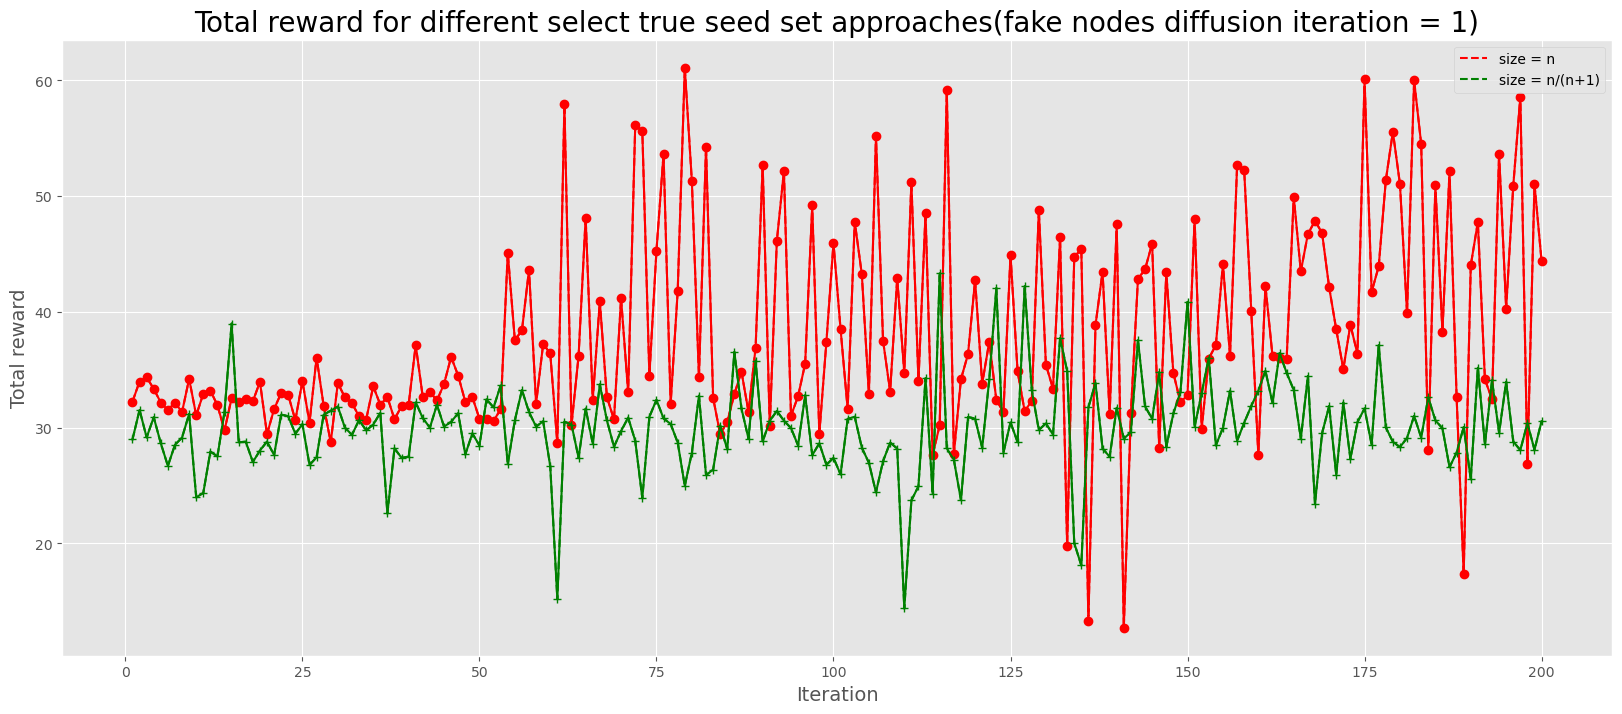

In [114]:
plt.figure(figsize=(20,8))
x = range(1,ALL_EPISODES+1)
plt.style.use('ggplot')
l1=plt.plot(x,rewards_list1,'r--',label='size = n')
l2=plt.plot(x,rewards_list1_1,'g--',label='size = n/(n+1)')
plt.plot(x,rewards_list1,'ro-',x,rewards_list1_1,'g+-')
plt.xlabel("Iteration", size = 14)
plt.ylabel("Total reward",size =14)
plt.title("Total reward for different select true seed set approaches(fake nodes diffusion iteration = 1)",size =20)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


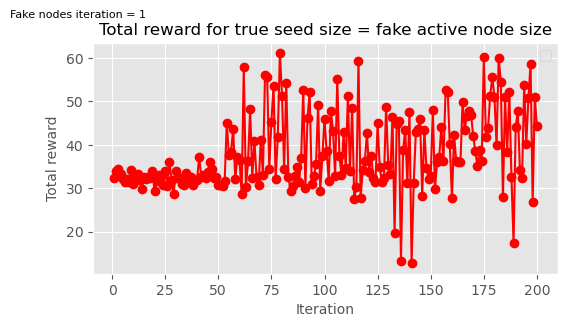

In [140]:
plt.figure(figsize=(6,3))
x = range(1,ALL_EPISODES+1)
plt.style.use('ggplot')
plt.plot(x,rewards_list1,'ro-')
plt.xlabel("Iteration",size = 10)
plt.ylabel("Total reward",size = 10)
plt.suptitle("Fake nodes iteration = 1",x=0.1,y= 0.99,size =8)
plt.title("Total reward for true seed size = fake active node size",size =12)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


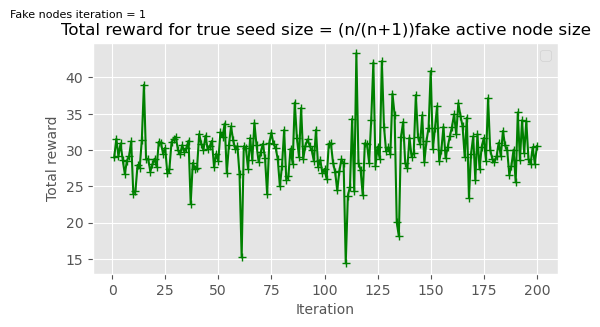

In [139]:
plt.figure(figsize=(6,3))
x = range(1,ALL_EPISODES+1)
plt.style.use('ggplot')
plt.plot(x,rewards_list1_1,'g+-')
plt.xlabel("Iteration",size = 10)
plt.ylabel("Total reward",size = 10)
plt.suptitle("Fake nodes iteration = 1",x=0.1,y= 0.99,size =8)
plt.title("Total reward for true seed size = (n/(n+1))fake active node size",size =12)

plt.legend()
plt.show()

### DEMO_FAKE_DIFF_ITER = 2

In [104]:
DEMO_FAKE_DIFF_ITER = 2
Demo_intial_train_graph2,Demo_active_fake_set2,Demo_intial_fake_set2,Demo_all_fake_nodes2 = generate_random_graph(DEMO_FAKE_DIFF_ITER,DEMO_M_INDEX,DEMO_FAKE_SEED_NUM,DEMO_NODE_NUM, DEMO_EDGE_NUM )
DEMO_SEED_SIZE = len(Demo_active_fake_set2)

In [105]:
Demo_env2 = Env(Demo_intial_train_graph2, DEMO_SEED_SIZE, Demo_active_fake_set2)

In [106]:
Demo_agent2 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)

In [107]:
state_history2, rewards_list2 = train_dqn(Demo_agent2, Demo_env2, ALL_EPISODES, batch_size ,UPDATE,dqn_agent_name ="Demo2.pth",Demo= True)

Episode 1/200, Total Reward: 31.55759781688485
Episode 2/200, Total Reward: 32.075888335974895
Episode 3/200, Total Reward: 32.99977991944781
Episode 4/200, Total Reward: 30.783265949244182
Episode 5/200, Total Reward: 31.01405501890064
Episode 6/200, Total Reward: 32.72262162080723
Episode 7/200, Total Reward: 34.32317809138671
Episode 8/200, Total Reward: 33.35543145732984
Episode 9/200, Total Reward: 31.888497270757917
Episode 10/200, Total Reward: 34.304148960755604
Episode 11/200, Total Reward: 30.750126746635512
Episode 12/200, Total Reward: 34.467688215408714


/var/folders/qd/bz9f8bp52sv9260n6zps4vbr0000gn/T/ipykernel_1187/545150970.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Episode 13/200, Total Reward: 32.70728781210423
Episode 14/200, Total Reward: 32.02934790355929
Episode 15/200, Total Reward: 32.53050241320232
Episode 16/200, Total Reward: 31.60012862719989
Episode 17/200, Total Reward: 30.65814718392265
Episode 18/200, Total Reward: 34.13229494728348
Episode 19/200, Total Reward: 30.75274195650052
Episode 20/200, Total Reward: 32.88320980376439
Episode 21/200, Total Reward: 32.920530701865964
Episode 22/200, Total Reward: 32.45979942962189
Episode 23/200, Total Reward: 31.900096049984683
Episode 24/200, Total Reward: 32.51558237946764
Episode 25/200, Total Reward: 33.814541703881645
Episode 26/200, Total Reward: 31.09610574404285
Episode 27/200, Total Reward: 32.34356327005399
Episode 28/200, Total Reward: 30.7539345406491
Episode 29/200, Total Reward: 31.973646296880403
Episode 30/200, Total Reward: 32.08227388013349
Episode 31/200, Total Reward: 30.26362660278551
Episode 32/200, Total Reward: 30.260110363929225
Episode 33/200, Total Reward: 33.214

Episode 181/200, Total Reward: 39.34119657763662
Episode 182/200, Total Reward: 39.449987462238745
Episode 183/200, Total Reward: 39.217479419633605
Episode 184/200, Total Reward: 39.33882609812335
Episode 185/200, Total Reward: 34.93485345087461
Episode 186/200, Total Reward: 41.517371641430515
Episode 187/200, Total Reward: 39.689338037463955
Episode 188/200, Total Reward: 32.3164462729463
Episode 189/200, Total Reward: 32.3062838225798
Episode 190/200, Total Reward: 41.22187070362469
Episode 191/200, Total Reward: 36.23114239878983
Episode 192/200, Total Reward: 32.96054285211456
Episode 193/200, Total Reward: 40.45152282143319
Episode 194/200, Total Reward: 41.92109167270632
Episode 195/200, Total Reward: 41.93596705683554
Episode 196/200, Total Reward: 40.50368919697054
Episode 197/200, Total Reward: 31.282098449309267
Episode 198/200, Total Reward: 43.09815380815219
Episode 199/200, Total Reward: 33.43832062184939
Episode 200/200, Total Reward: 41.7838756732895


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


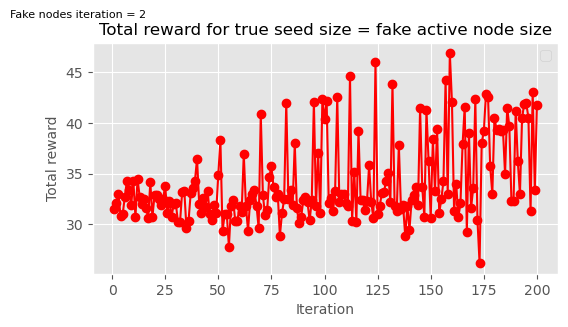

In [137]:
plt.figure(figsize=(6,3))
x = range(1,ALL_EPISODES+1)
plt.style.use('ggplot')
plt.plot(x,rewards_list2,'ro-')
plt.xlabel("Iteration",size = 10)
plt.ylabel("Total reward",size = 10)
plt.suptitle("Fake nodes iteration = 2",x=0.1,y= 0.99,size =8)
plt.title("Total reward for true seed size = fake active node size",size =12)
plt.legend()
plt.show()

In [108]:
DEMO_SEED_SIZE = int((DEMO_FAKE_DIFF_ITER/(DEMO_FAKE_DIFF_ITER+1))*len(Demo_active_fake_set2))
print(DEMO_SEED_SIZE)

9


In [109]:
len(Demo_active_fake_set2)

14

In [110]:
Demo_env2_1 = Env(Demo_intial_train_graph2, DEMO_SEED_SIZE, Demo_active_fake_set2)

In [111]:
Demo_agent2_1 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)

In [112]:
state_history2_1, rewards_list2_1 = train_dqn(Demo_agent2_1, Demo_env2_1, ALL_EPISODES, batch_size ,UPDATE,dqn_agent_name ="Demo2_1.pth",Demo= True)

Episode 1/200, Total Reward: 30.489040125522
Episode 2/200, Total Reward: 31.42400879533162
Episode 3/200, Total Reward: 29.29819724651506
Episode 4/200, Total Reward: 28.45545707953028
Episode 5/200, Total Reward: 27.83063450002217
Episode 6/200, Total Reward: 30.624017283449167
Episode 7/200, Total Reward: 31.117632366262097
Episode 8/200, Total Reward: 31.229329039212523
Episode 9/200, Total Reward: 31.216705042710437
Episode 10/200, Total Reward: 31.23920185528967
Episode 11/200, Total Reward: 31.979069632643622
Episode 12/200, Total Reward: 30.689340602351486


/var/folders/qd/bz9f8bp52sv9260n6zps4vbr0000gn/T/ipykernel_1187/545150970.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Episode 13/200, Total Reward: 32.265894926066984
Episode 14/200, Total Reward: 30.847527846855304
Episode 15/200, Total Reward: 33.583338389504874
Episode 16/200, Total Reward: 29.779107973253037
Episode 17/200, Total Reward: 27.902905697889093
Episode 18/200, Total Reward: 33.94818364786962
Episode 19/200, Total Reward: 28.935461702544604
Episode 20/200, Total Reward: 30.127292442934813
Episode 21/200, Total Reward: 32.59049430909277
Episode 22/200, Total Reward: 32.5570418154144
Episode 23/200, Total Reward: 32.011016398645566
Episode 24/200, Total Reward: 29.35660069988389
Episode 25/200, Total Reward: 29.97753185591454
Episode 26/200, Total Reward: 30.580510082851
Episode 27/200, Total Reward: 30.570465295857193
Episode 28/200, Total Reward: 28.107110539891035
Episode 29/200, Total Reward: 30.483735010138894
Episode 30/200, Total Reward: 28.643531189643717
Episode 31/200, Total Reward: 32.39076388284353
Episode 32/200, Total Reward: 30.260937666961166
Episode 33/200, Total Reward: 

Episode 181/200, Total Reward: 33.42156725587493
Episode 182/200, Total Reward: 34.354060992934436
Episode 183/200, Total Reward: 34.77847762552655
Episode 184/200, Total Reward: 35.85184637174681
Episode 185/200, Total Reward: 36.73042762702881
Episode 186/200, Total Reward: 27.901766172908104
Episode 187/200, Total Reward: 35.15247888772333
Episode 188/200, Total Reward: 28.393664045540355
Episode 189/200, Total Reward: 30.730303926967977
Episode 190/200, Total Reward: 33.25659758725405
Episode 191/200, Total Reward: 31.1325345004302
Episode 192/200, Total Reward: 34.84777458673652
Episode 193/200, Total Reward: 32.45031834416617
Episode 194/200, Total Reward: 31.937195404232654
Episode 195/200, Total Reward: 26.69320548746699
Episode 196/200, Total Reward: 40.89696819172035
Episode 197/200, Total Reward: 18.657015768209
Episode 198/200, Total Reward: 41.034352758957695
Episode 199/200, Total Reward: 30.49041506706234
Episode 200/200, Total Reward: 28.324293024873178


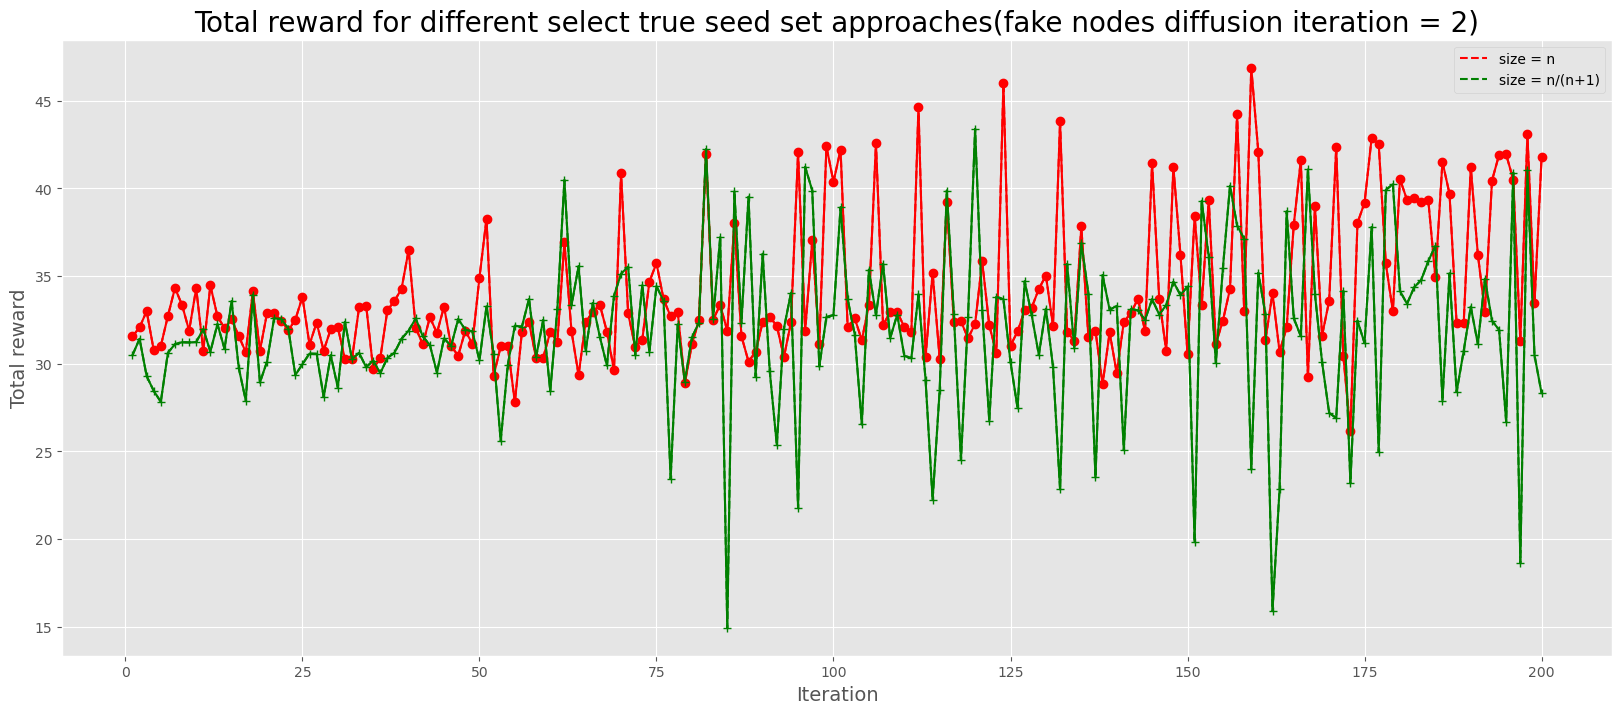

In [115]:
plt.figure(figsize=(20,8))
x = range(1,ALL_EPISODES+1)
plt.style.use('ggplot')
l1=plt.plot(x,rewards_list2,'r--',label='size = n')
l2=plt.plot(x,rewards_list2_1,'g--',label='size = n/(n+1)')
plt.plot(x,rewards_list2,'ro-',x,rewards_list2_1,'g+-')
plt.xlabel("Iteration", size = 14)
plt.ylabel("Total reward",size =14)
plt.title("Total reward for different select true seed set approaches(fake nodes diffusion iteration = 2)",size =20)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


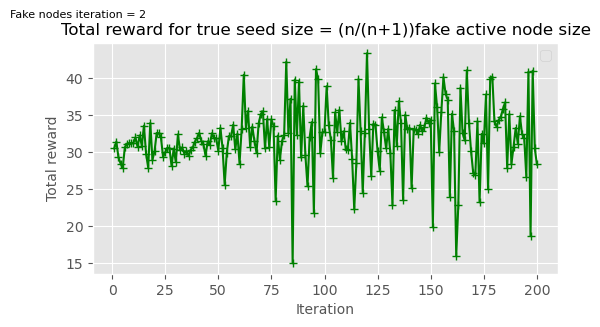

In [138]:
plt.figure(figsize=(6,3))
x = range(1,ALL_EPISODES+1)
plt.style.use('ggplot')
plt.plot(x,rewards_list2_1,'g+-')
plt.xlabel("Iteration",size = 10)
plt.ylabel("Total reward",size = 10)
plt.suptitle("Fake nodes iteration = 2",x=0.1,y= 0.99,size =8)
plt.title("Total reward for true seed size = (n/(n+1))fake active node size",size =12)
plt.legend()
plt.show()

MovieWriter Pillow unavailable; using Pillow instead.


<Figure size 1000x1000 with 0 Axes>

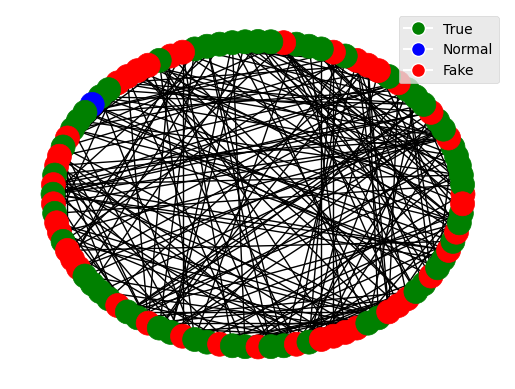

In [187]:
from matplotlib.lines import Line2D
display(state_history1_1)